In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as ms

ms.use('seaborn-muted')
%matplotlib inline
import librosa
import librosa.display

# загрузка mp3 файлов
import audioread.ffdec  # Use ffmpeg decoder
import ffmpeg

from glob import glob
import os

#pytorch
import torch
import torch.nn as nn
from torchvision import transforms

from PIL import Image
from sklearn.metrics import accuracy_score

In [2]:
songs_dir = './music'
songs_names = glob(songs_dir+ "\*.wav")
y, sr = librosa.load(audioread.ffdec.FFmpegAudioFile(songs_names[0]))

In [66]:
songs_dir = './music'
songs_names = glob(songs_dir+ "\*.mp3")
noise_y, sr = librosa.load(audioread.ffdec.FFmpegAudioFile(songs_names[-1]))

In [43]:
np.random.random(len(y))*0.1 + y

array([0.10604518, 0.18214104, 0.07584223, ..., 0.00730458, 0.13195351,
       0.02196045])

In [47]:
newy = np.array([j * i / len(y) for i, j in enumerate(y)])

In [62]:
newy = np.array([j *0.5 for i, j in enumerate(y)])


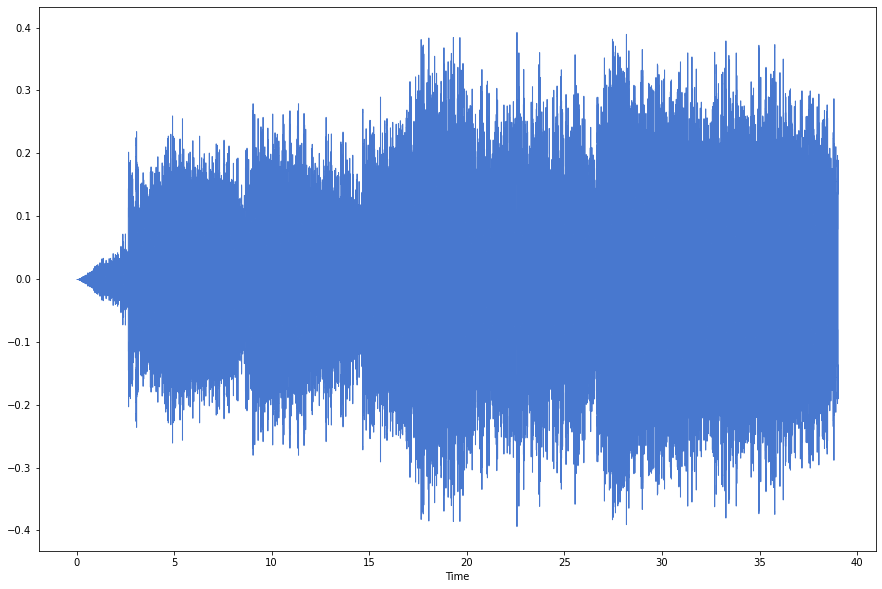

In [68]:
plt.figure(figsize=(15,10))
librosa.display.waveshow(y * 2 + noise_y[:len(y)]  , sr=sr, marker='.', label='Full signal')

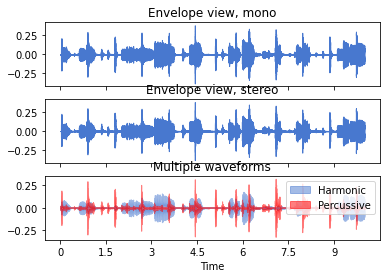

In [8]:
y, sr = librosa.load(librosa.ex('choice'), duration=10)
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

y, sr = librosa.load(librosa.ex('choice', hq=True), mono=False, duration=10)
librosa.display.waveshow(y, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

y, sr = librosa.load(librosa.ex('choice'), duration=10)
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms')
ax[2].legend()



NameError: name 'y_harm' is not defined

<Figure size 1080x720 with 0 Axes>

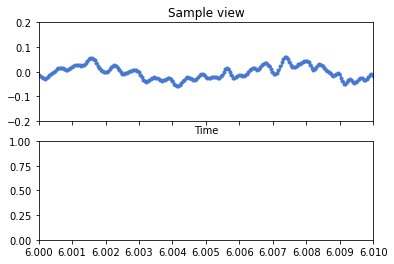

In [11]:
plt.figure(figsize=(15, 10))
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
ax.set(xlim=[6.0, 6.01], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend()
ax2.legend()

In [12]:
7.5*22050

165375.0

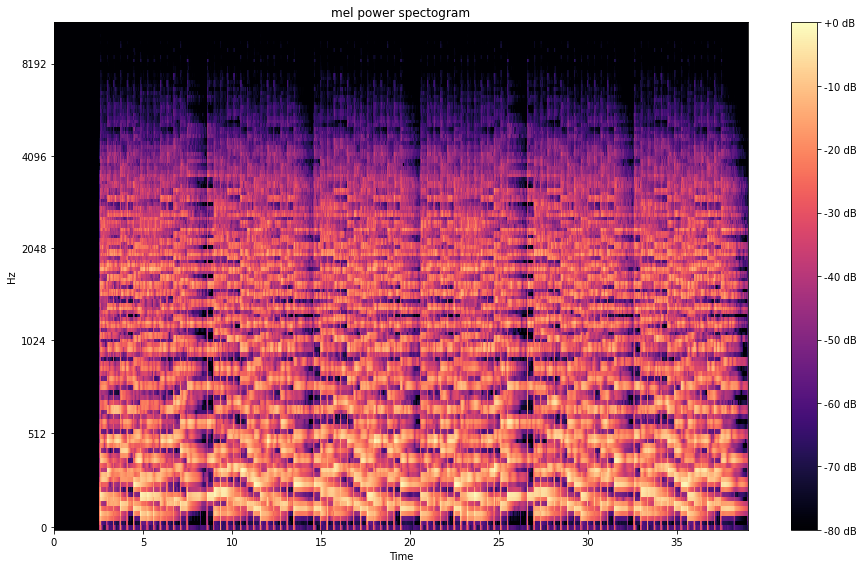

In [35]:
#Mel Spectogram
S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128)

#convert to log scale
log_S = librosa.power_to_db(S, ref = np.max)

#display the spectogram on a mel scale
# sample rate and hop length parameters are used to rener the time axis
plt.figure(figsize=(13, 8))
librosa.display.specshow(log_S, sr = sr, x_axis = 'time', y_axis = 'mel')


plt.title('mel power spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

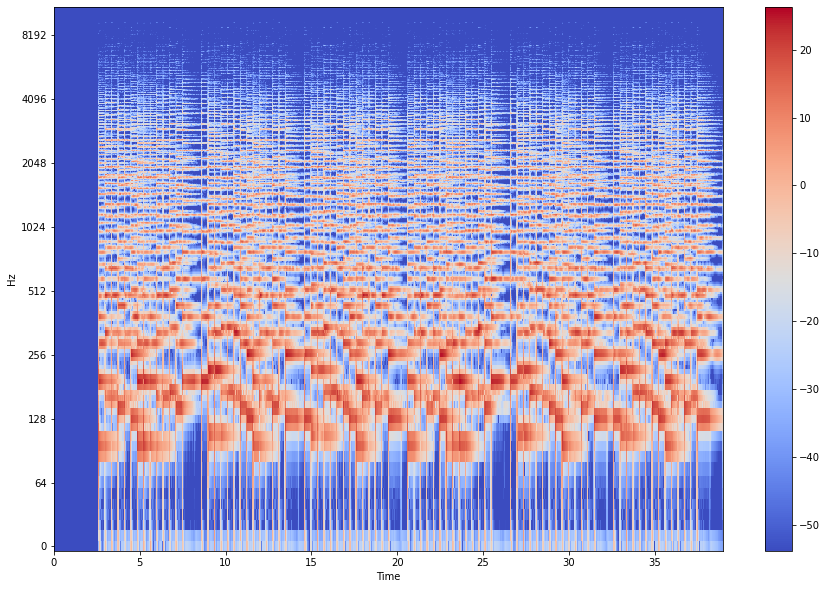

In [29]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 10))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')#, y_axis='hz')
plt.colorbar()

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


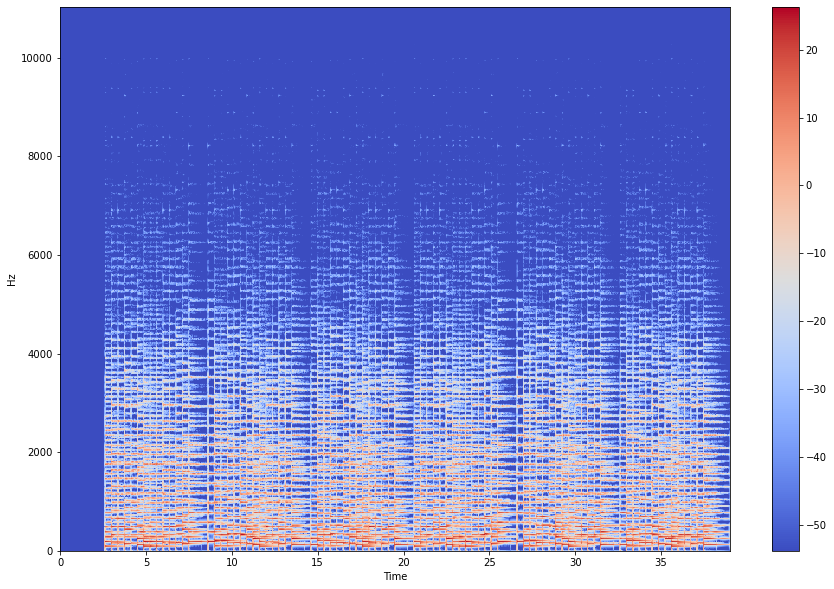

In [16]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(X)
np.array(Xdb).astype('uint8')
plt.figure(figsize=(15, 10))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

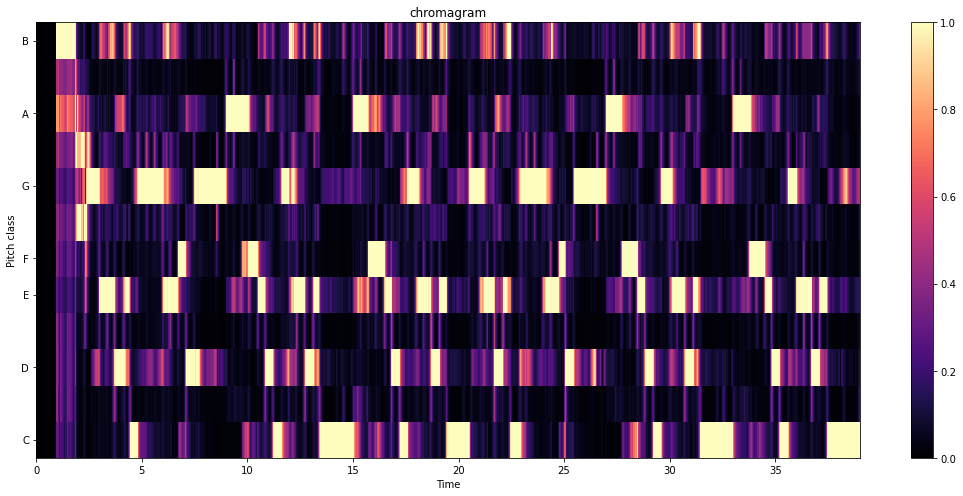

In [37]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

C = librosa.feature.chroma_cqt(y=y_harmonic, sr = sr)

plt.figure(figsize=(15, 7))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis = 'chroma', vmin = 0, vmax = 1)

#plt.figure(figsize=(15, 10))
plt.title("chromagram")
plt.colorbar()
plt.tight_layout()


In [ ]:
songs_dir = './csv_data'
songs_names = glob(songs_dir+ "\*.csv")


In [ ]:
torch.ToTensor()

In [ ]:
def load_cens_pandas(load_dir):
    df = pd.DataFrame()
    songs_names = glob(songs_dir+ "\*.csv")
    train_songs_names= [song.split('\\')[-1].split('.')[0] for song in songs_names]
    y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
    for i, song_name in enumerate(songs_names):
        df_to_merge = pd.read_csv(song_name, skiprows = 1, header = None)
        df_to_merge['y'] = np.full(len(df_to_merge), i) 
        df = pd.concat([df, df_to_merge])
    return y_dict_reverse, df

In [ ]:
csv_dir = './csv_data'    
rev_dict, df = load_cens_pandas(csv_dir)
X = df.drop('y', axis = 1)
y = df['y']

In [2]:
class CENSDataset(torch.utils.data.Dataset):   
    def __init__(self, dir_names):
        
        self.transform = transforms.Compose(
            [
                #transforms.Resize((10,10)), 
                transforms.ToTensor()
            ]
        )
        data = []
        y = []
        self.dir_names = dir_names
        
        train_songs_names= [song.split('\\')[-1] for song in dir_names]
        
        self.y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
        for i, dir_name in enumerate(dir_names):
            song_names = glob(dir_name + "\*.jpeg")
            for song in song_names:
                img = Image.open(song)
                data.append(self.transform(img))
                y.append(i)
        
        self.data = torch.cat(data).unsqueeze(1)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        
        img = self.data[index]      
        target = self.y[index]
        
        return img, target
    
    def get_number_of_classes(self):
        return len(np.unique(self.y))

In [70]:
class CensSpecDataset(torch.utils.data.Dataset):   
    def __init__(self, dir_names_cens, dir_names_spec):
        
        self.transform = transforms.Compose(
            [
                #transforms.Resize((10,10)), 
                transforms.ToTensor()
            ]
        )
        data = []
        y = []
        self.dir_names_cens = dir_names_cens
        self.dir_names_spec = dir_names_spec
        
        train_songs_names= [song.split('\\')[-1] for song in self.dir_names_cens]
        
        self.y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
        for i, dir_name in enumerate(self.dir_names_cens):
            song_names_cens = glob(self.dir_names_cens[i] + "\*.jpeg")
            song_names_spec = glob(self.dir_names_spec[i] + "\*.jpeg")
            for j in range(len(song_names_cens)):   
                img_cens = Image.open(song_names_cens[j])
                img_spec = Image.open(song_names_spec[j])
                data.append([self.transform(img_cens), self.transform(img_spec)])
                y.append(i)
        
        self.data = data#torch.cat(data).unsqueeze(1)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        
        img_cens = self.data[index][0]
        img_spec = self.data[index][1]
        target = self.y[index]
        
        return img_cens, img_spec, target
    
    def get_number_of_classes(self):
        return len(np.unique(self.y))

In [76]:
csv_dir = './images' 
cens_data = r"E:\data\zamzam\cens"
cens_directories = [song[0] for song in os.walk(cens_data)][1:]

spec_data = r"E:\data\zamzam\\spec"
spec_directories = [song[0] for song in os.walk(spec_data)][1:]


In [72]:
dataset = CensSpecDatasetWithoutLoading(cens_directories, spec_directories)

NameError: name 'CensSpecDatasetWithoutLoading' is not defined

In [77]:
dataset = CensSpecDataset(cens_directories, spec_directories)

In [17]:
dataset = CENSDataset(cens_directories)

In [21]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [18000, 2556])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

# 2

In [22]:
class NN2(nn.Module):
    def __init__(self, num_class):
        super(NN2, self).__init__()
        
        self.num_class = num_class
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.conv_layer1 = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))#20
        
        self.conv_layer2 = nn.Conv2d(20, 40, (1, 4), stride=(1, 2))#50
        
        self.conv_layer3 = nn.Conv2d(40, 80, (4, 2))#100
        
        self.conv_layer4 = nn.Conv2d(80, 160, (2, 2))#200
        
        self.conv_layer5 = nn.Conv2d(160, 320, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=320, out_features=320)
        
        self.linear_layer2 = nn.Linear(in_features=320, out_features=self.num_class)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs):
        res = self.batchnorm_0(inputs)
        res = self.relu(self.conv_layer1(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer2(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer3(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer4(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.conv_layer5(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        res = self.linear_layer2(res)
        return res

In [24]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')

In [25]:
np.random.seed(42)
torch.manual_seed(42)

model = NN2(dataset.get_number_of_classes()).to(device)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

num_epochs = 100
history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    for num_batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.reshape(-1, 1).to(device)     
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 10 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            pred = model(images.to(device))
            pred = pred.to(cpu)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %')

Epoch: 1, Accuracy: 4.9687 %
Epoch: 2, Accuracy: 5.4382 %
Epoch: 3, Accuracy: 5.2817 %
Epoch: 4, Accuracy: 5.3599 %
Epoch: 5, Accuracy: 5.5164 %
Epoch: 6, Accuracy: 5.3599 %
Epoch: 7, Accuracy: 5.3208 %
Epoch: 8, Accuracy: 5.4382 %
Epoch: 9, Accuracy: 5.3991 %
Epoch: 10, Accuracy: 5.4382 %
Epoch: 11, Accuracy: 5.2817 %
Epoch: 12, Accuracy: 5.3991 %
Epoch: 13, Accuracy: 5.4773 %
Epoch: 14, Accuracy: 5.4773 %
Epoch: 15, Accuracy: 5.2817 %
Epoch: 16, Accuracy: 5.3599 %
Epoch: 17, Accuracy: 5.3599 %
Epoch: 18, Accuracy: 5.4382 %
Epoch: 19, Accuracy: 5.3991 %
Epoch: 20, Accuracy: 5.4382 %
Epoch: 21, Accuracy: 5.3991 %
Epoch: 22, Accuracy: 5.3599 %
Epoch: 23, Accuracy: 5.4382 %
Epoch: 24, Accuracy: 5.3208 %
Epoch: 25, Accuracy: 5.3599 %
Epoch: 26, Accuracy: 5.3208 %
Epoch: 27, Accuracy: 5.2817 %
Epoch: 28, Accuracy: 5.3991 %
Epoch: 29, Accuracy: 5.2817 %
Epoch: 30, Accuracy: 5.4382 %
Epoch: 31, Accuracy: 5.3208 %
Epoch: 32, Accuracy: 5.3208 %
Epoch: 33, Accuracy: 5.2817 %
Epoch: 34, Accuracy

KeyboardInterrupt: 

In [54]:
print(max(history))
plt.plot(history)

ValueError: max() arg is an empty sequence

# 3

In [ ]:
cens, spec, label = dataset[0]
cens, spec = cens.unsqueeze(0), spec.unsqueeze(0)

In [ ]:
#3 spec
num_class = dataset.get_number_of_classes()
max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)

m = nn.Conv2d(1, 30, (4, 4), stride=(1, 1))
output = m(spec)



m = nn.Conv2d(30, 60, (4, 6), stride=(1,2))
output = m(output)
output = max_pooling_layer_2(output)

m = nn.Conv2d(60, 120, (4, 4), stride=(1,2))
output = m(output)
output = max_pooling_layer_2(output)

m = nn.Conv2d(120, 240, (12, 1), stride=(1,1))
output = m(output)
output = max_pooling_layer_2(output)
"""
m = nn.Conv2d(80, 80, (8, 1), stride=(3,1))
output = m(output)
output_spec = max_pooling_layer_2(output)



m = nn.Conv2d(100, 200, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)

m = nn.Conv2d(200, 400, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)"""
output.size()

In [ ]:
#2
num_class = dataset.get_number_of_classes()
max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)

m = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))
output = m(cens)
output = max_pooling_layer_1(output)

m = nn.Conv2d(20, 50, (1, 4), stride=(1, 2))
output = m(output)
output = max_pooling_layer_1(output)

m = nn.Conv2d(50, 100, (4, 2))
output = m(output)
output_cens = max_pooling_layer_1(output)
"""
m = nn.Conv2d(100, 200, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)

m = nn.Conv2d(200, 400, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)"""
output_cens.size()

In [ ]:
output = torch.cat([output_cens, output_spec], dim = 1)
output.size()

In [ ]:
m = nn.Conv2d(200, 400, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)
m = nn.Conv2d(400, 800, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)
output.size()

In [48]:
class NN3(nn.Module):
    def __init__(self, num_class):
        super(NN3, self).__init__()
        
        self.num_class = num_class
        #cens
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.cens_conv_layer1 = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))#20
        
        self.cens_conv_layer2 = nn.Conv2d(20, 40, (1, 4), stride=(1, 2))#50
        
        self.cens_conv_layer3 = nn.Conv2d(40, 80, (4, 2))#100
        
        self.cens_conv_layer4 = nn.Conv2d(80, 160, (2, 2))#200
        
        self.cens_conv_layer5 = nn.Conv2d(160, 320, (2, 2))#400
        
        self.cens_linear_layer = nn.Linear(in_features=320, out_features=320)
        #spec
        self.spec_conv_layer1 = nn.Conv2d(1, 30, (4, 4), stride=(1, 1))
        
        self.spec_conv_layer2 = nn.Conv2d(30, 60, (4, 6), stride=(1,2))

        self.spec_conv_layer3 = nn.Conv2d(60, 80, (4, 4), stride=(1,2))
        
        self.spec_conv_layer4  = nn.Conv2d(80, 160, (12, 1), stride=(1,1))
        
        self.spec_conv_layer5 = nn.Conv2d(160, 240, (2, 2))#200
        
        self.spec_conv_layer6 = nn.Conv2d(240, 320, (2, 2))#400
        
        self.spec_linear_layer = nn.Linear(in_features=320, out_features=320)
        
        # sum     
        self.sum_linear_layer = nn.Linear(in_features=640, out_features=self.num_class)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, cens_inputs, spec_inputs):
        #cens
        cens = self.batchnorm_0(cens_inputs)
        cens = self.relu(self.cens_conv_layer1(cens))
        cens = self.max_pooling_layer_1(cens)
        
        cens = self.relu(self.cens_conv_layer2(cens))
        cens = self.max_pooling_layer_1(cens)
        
        cens = self.relu(self.cens_conv_layer3(cens))
        cens = self.max_pooling_layer_1(cens)
        
        cens = self.relu(self.cens_conv_layer4(cens))
        cens = self.max_pooling_layer_2(cens)
        
        cens = self.relu(self.cens_conv_layer5(cens))
        cens = self.max_pooling_layer_2(cens)
        
        cens = torch.flatten(cens, 1)
        
        cens = self.relu(self.cens_linear_layer(cens))
        #spec
        spec = self.batchnorm_0(spec_inputs)
        spec = self.relu(self.spec_conv_layer1(spec))
        
        spec = self.relu(self.spec_conv_layer2(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer3(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer4(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer5(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer6(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = torch.flatten(spec, 1)
        
        spec = self.relu(self.spec_linear_layer(spec))
        #sum
        res = torch.cat([cens, spec], dim = 1)
        
        res = self.sum_linear_layer(res)
        return res

In [49]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [18000, 2556])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [54]:
np.random.seed(42)
torch.manual_seed(42)

model = NN3(dataset.get_number_of_classes()).to(device)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

num_epochs = 50
history = []

In [55]:
torch.cuda.empty_cache()
for epoch in range(1, num_epochs + 1):
    model.train()
    for num_batch, (images_cens, images_spec, labels) in enumerate(train_loader):
        #images_cens, images_spec = images_cens.unsqueeze(0), images_spec.unsqueeze(0)
        images_cens, images_spec = images_cens.to(device), images_spec.to(device)
        
        labels = labels.reshape(-1, 1).to(device)
        
        optimizer.zero_grad()
        pred = model(images_cens, images_spec)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 1 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images_cens, images_spec, labels in val_loader:
            images_cens = images_cens.to(device)
            images_spec = images_spec.to(device)
            pred = model(images_cens, images_spec)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %, Loss: {loss.item():.4f}')

Epoch: 1, Accuracy: 13.7715 %, Loss: 2.7249
Epoch: 2, Accuracy: 22.9264 %, Loss: 1.2645
Epoch: 3, Accuracy: 27.2300 %, Loss: 0.3091


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "cens_spec.txt")

In [9]:
class NN3_spec(nn.Module):
    def __init__(self, num_class):
        super(NN3_spec, self).__init__()
        
        self.num_class = num_class
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)

        #spec
        self.spec_conv_layer1 = nn.Conv2d(1, 30, (4, 4), stride=(1, 1))
        
        self.spec_conv_layer2 = nn.Conv2d(30, 60, (4, 6), stride=(1,2))

        self.spec_conv_layer3 = nn.Conv2d(60, 80, (4, 4), stride=(1,2))
        
        self.spec_conv_layer4  = nn.Conv2d(80, 160, (12, 1), stride=(1,1))
        
        # sum
        self.sum_conv_layer1 = nn.Conv2d(160, 240, (2, 2))#200
        
        self.sum_conv_layer2 = nn.Conv2d(240, 360, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=360, out_features=360)
        
        self.linear_layer2 = nn.Linear(in_features=360, out_features=self.num_class)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, cens_inputs, spec_inputs):

        #spec
        spec = self.batchnorm_0(spec_inputs)
        spec = self.relu(self.spec_conv_layer1(spec))
        
        spec = self.relu(self.spec_conv_layer2(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer3(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer4(spec))
        spec = self.max_pooling_layer_2(spec)
        
        #sum
        #res = torch.cat([cens, spec], dim = 1)
        res = spec
        res = self.relu(self.sum_conv_layer1(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.sum_conv_layer2(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        res = self.linear_layer2(res)
        return res

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
device = torch.device('cpu')

In [14]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [18000, 2556])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [11]:
model_spec = NN3_spec(dataset.get_number_of_classes()).to(device)
model_spec.load_state_dict(torch.load("spec.txt"))

<All keys matched successfully>

In [ ]:
model_spec = NN3_spec(dataset.get_number_of_classes()).to(device)

In [12]:
np.random.seed(42)
torch.manual_seed(42)



criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model_spec.parameters(), lr=0.01)

num_epochs = 20
history = []

In [15]:
torch.cuda.empty_cache()
for epoch in range(1, num_epochs + 1):
    model_spec.train()
    for num_batch, (images_cens, images_spec, labels) in enumerate(train_loader):
        #images_cens, images_spec = images_cens.unsqueeze(0), images_spec.unsqueeze(0)
        images_cens, images_spec = images_cens.to(device), images_spec.to(device)
        
        labels = labels.reshape(-1, 1).to(device)
        
        optimizer.zero_grad()
        pred = model_spec(images_cens, images_spec)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 1 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model_spec.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images_cens, images_spec, labels in val_loader:
            images_cens = images_cens.to(device)
            images_spec = images_spec.to(device)
            pred = model_spec(images_cens, images_spec)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %, Loss: {loss.item():.4f}')

Epoch: 1, Accuracy: 68.6228 %, Loss: 1.0629
Epoch: 2, Accuracy: 80.9468 %, Loss: 0.7373
Epoch: 3, Accuracy: 85.4851 %, Loss: 0.3349
Epoch: 4, Accuracy: 88.3803 %, Loss: 0.0248
Epoch: 5, Accuracy: 88.3412 %, Loss: 0.0781
Epoch: 6, Accuracy: 88.9671 %, Loss: 0.2542
Epoch: 7, Accuracy: 89.9844 %, Loss: 0.0719
Epoch: 8, Accuracy: 89.1236 %, Loss: 0.0602
Epoch: 9, Accuracy: 89.8279 %, Loss: 0.1170
Epoch: 10, Accuracy: 90.2191 %, Loss: 0.1504
Epoch: 11, Accuracy: 89.6322 %, Loss: 0.0958
Epoch: 12, Accuracy: 90.4538 %, Loss: 0.4255
Epoch: 13, Accuracy: 90.0235 %, Loss: 0.1139
Epoch: 14, Accuracy: 89.1628 %, Loss: 0.0015
Epoch: 15, Accuracy: 89.3192 %, Loss: 0.0156
Epoch: 16, Accuracy: 89.6322 %, Loss: 0.0153
Epoch: 17, Accuracy: 90.1800 %, Loss: 0.1053
Epoch: 18, Accuracy: 89.7496 %, Loss: 0.0002
Epoch: 19, Accuracy: 90.3365 %, Loss: 0.1021
Epoch: 20, Accuracy: 90.0626 %, Loss: 0.0113


In [32]:
torch.save(model_spec.state_dict(), "spec.txt")

In [55]:
cpu = torch.device('cpu')
model.eval()
acc = list()
with torch.no_grad():
        for images_cens, images_spec, labels in val_loader:
            images_cens = images_cens.to(device)
            images_spec = images_spec.to(device)
            pred = model(images_cens, images_spec)
            pred = pred.to(cpu)
            """for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred"""
            acc.append(accuracy_score(labels, torch.argmax(pred, dim = 1)))

In [6]:
class NN3_cens(nn.Module):
    def __init__(self, num_class):
        super(NN3_cens, self).__init__()
        
        self.num_class = num_class
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.conv_layer1 = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))#20
        
        self.conv_layer2 = nn.Conv2d(20, 40, (1, 4), stride=(1, 2))#50
        
        self.conv_layer3 = nn.Conv2d(40, 80, (4, 2))#100
        
        self.conv_layer4 = nn.Conv2d(80, 160, (2, 2))#200
        
        self.conv_layer5 = nn.Conv2d(160, 320, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=320, out_features=320)
        
        self.linear_layer2 = nn.Linear(in_features=320, out_features=self.num_class)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs_cens, inputs_spec):
        res = self.batchnorm_0(inputs_cens)
        res = self.relu(self.conv_layer1(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer2(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer3(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer4(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.conv_layer5(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        res = self.linear_layer2(res)
        return res

In [7]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [18000, 2556])
train_loader_cens = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [8]:
model_cens = NN3_cens(dataset.get_number_of_classes()).to(device)
model_cens.load_state_dict(torch.load("cens_model.txt"))

<All keys matched successfully>

In [18]:
model_cens = NN3_cens(dataset.get_number_of_classes()).to(device)
model_cens.load_state_dict(torch.load("cens_model.txt"))
model_cens.eval()
correct = 0
total = 0
with torch.no_grad():
    for images_cens, images_spec, labels in val_loader:
        images_cens = images_cens.to(device)
        images_spec = images_spec.to(device)
        pred = model_cens(images_cens, images_spec)
        for i, pr in enumerate(pred):
            if torch.argmax(pr) == labels[i]:
                correct += 1
        total += len(pred)
            
    history.append(100 * correct / total)
    print(f'Accuracy: {100 * correct / total:.4f} %, Loss: {loss.item():.4f}')

Accuracy: 92.0188 %, Loss: 0.0152


In [14]:
np.random.seed(42)
torch.manual_seed(42)
model_cens = NN3_cens(dataset.get_number_of_classes()).to(device)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model_cens.parameters(), lr=0.03)

num_epochs = 100
history = []

In [15]:
torch.cuda.empty_cache()
for epoch in range(1, num_epochs + 1):
    model_cens.train()
    for num_batch, (images_cens, images_spec, labels) in enumerate(train_loader_cens):
        #images_cens, images_spec = images_cens.unsqueeze(0), images_spec.unsqueeze(0)
        images_cens, images_spec = images_cens.to(device), images_spec.to(device)
        
        labels = labels.reshape(-1, 1).to(device)
        
        optimizer.zero_grad()
        pred = model_cens(images_cens, images_spec)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 1 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model_cens.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images_cens, images_spec, labels in val_loader:
            images_cens = images_cens.to(device)
            images_spec = images_spec.to(device)
            pred = model_cens(images_cens, images_spec)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %, Loss: {loss.item():.4f}')

Epoch: 1, Accuracy: 11.1502 %, Loss: 3.4851
Epoch: 2, Accuracy: 39.2410 %, Loss: 2.1681
Epoch: 3, Accuracy: 60.4851 %, Loss: 1.1325
Epoch: 4, Accuracy: 67.4491 %, Loss: 1.4448
Epoch: 5, Accuracy: 77.2300 %, Loss: 0.7999
Epoch: 6, Accuracy: 79.9296 %, Loss: 0.3284
Epoch: 7, Accuracy: 80.9859 %, Loss: 1.0213
Epoch: 8, Accuracy: 81.4554 %, Loss: 0.6555
Epoch: 9, Accuracy: 86.1894 %, Loss: 0.1016
Epoch: 10, Accuracy: 87.7152 %, Loss: 0.1896
Epoch: 11, Accuracy: 89.0454 %, Loss: 0.3377
Epoch: 12, Accuracy: 88.3803 %, Loss: 0.7333
Epoch: 13, Accuracy: 88.6541 %, Loss: 0.1108
Epoch: 14, Accuracy: 90.3756 %, Loss: 0.2358
Epoch: 15, Accuracy: 90.8451 %, Loss: 0.1072
Epoch: 16, Accuracy: 90.9624 %, Loss: 0.1142
Epoch: 17, Accuracy: 90.1408 %, Loss: 0.0998
Epoch: 18, Accuracy: 90.2191 %, Loss: 0.0040
Epoch: 19, Accuracy: 91.3928 %, Loss: 0.1384
Epoch: 20, Accuracy: 91.1189 %, Loss: 0.1702
Epoch: 21, Accuracy: 91.1581 %, Loss: 0.0030
Epoch: 22, Accuracy: 91.3537 %, Loss: 0.0003
Epoch: 23, Accuracy

KeyboardInterrupt: 

In [17]:
torch.save(model_cens.state_dict(), "cens.txt")

# Суммарная модель
### Загрузка обученных моделей

Загрузка и удаление лишних слоёв

In [80]:
cens_dict = torch.load("cens.txt")
spec_dict = torch.load("spec.txt")

del cens_dict['linear_layer2.weight']
del cens_dict['linear_layer2.bias']

del spec_dict['linear_layer2.weight']
del spec_dict['linear_layer2.bias']

Задание изменённых моделей

In [81]:
class NN4_cens(nn.Module):
    def __init__(self):
        super(NN4_cens, self).__init__()
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.conv_layer1 = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))#20
        
        self.conv_layer2 = nn.Conv2d(20, 40, (1, 4), stride=(1, 2))#50
        
        self.conv_layer3 = nn.Conv2d(40, 80, (4, 2))#100
        
        self.conv_layer4 = nn.Conv2d(80, 160, (2, 2))#200
        
        self.conv_layer5 = nn.Conv2d(160, 320, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=320, out_features=320)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs_cens, inputs_spec):
        res = self.batchnorm_0(inputs_cens)
        res = self.relu(self.conv_layer1(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer2(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer3(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer4(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.conv_layer5(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        return res
    
class NN4_spec(nn.Module):
    def __init__(self):
        super(NN4_spec, self).__init__()
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)

        #spec
        self.spec_conv_layer1 = nn.Conv2d(1, 30, (4, 4), stride=(1, 1))
        
        self.spec_conv_layer2 = nn.Conv2d(30, 60, (4, 6), stride=(1,2))

        self.spec_conv_layer3 = nn.Conv2d(60, 80, (4, 4), stride=(1,2))
        
        self.spec_conv_layer4  = nn.Conv2d(80, 160, (12, 1), stride=(1,1))
        
        # sum
        self.sum_conv_layer1 = nn.Conv2d(160, 240, (2, 2))#200
        
        self.sum_conv_layer2 = nn.Conv2d(240, 360, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=360, out_features=360)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, cens_inputs, spec_inputs):

        #spec
        spec = self.batchnorm_0(spec_inputs)
        spec = self.relu(self.spec_conv_layer1(spec))
        
        spec = self.relu(self.spec_conv_layer2(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer3(spec))
        spec = self.max_pooling_layer_2(spec)
        
        spec = self.relu(self.spec_conv_layer4(spec))
        spec = self.max_pooling_layer_2(spec)
        
        #sum
        #res = torch.cat([cens, spec], dim = 1)
        res = spec
        res = self.relu(self.sum_conv_layer1(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.sum_conv_layer2(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        return res

In [82]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')
cens_model = NN4_cens().to(device)
cens_model.load_state_dict(cens_dict)

spec_model = NN4_spec().to(device)
spec_model.load_state_dict(spec_dict)

<All keys matched successfully>

Суммарная модель

In [83]:
class NN4_sum(nn.Module):
    def __init__(self, num_class, model_cens, model_spec):
        super(NN4_sum, self).__init__()
        
        self.num_class = num_class
        
        self.model_cens = model_cens
        self.model_spec = model_spec
        
        self.model_cens.eval()
        self.model_spec.eval()
        
        self.linear_layer1 = nn.Linear(in_features=680, out_features=self.num_class)
        
    def forward(self, cens_inputs, spec_inputs):

        cens = self.model_cens(cens_inputs, spec_inputs)
        spec = self.model_spec(cens_inputs, spec_inputs)
        
        res = torch.cat([cens, spec], dim = 1)
        
        res = self.linear_layer1(res)
        
        return res

In [84]:
sum_model = NN4_sum(dataset.get_number_of_classes(), cens_model, spec_model).to(device)

In [85]:
sum_model = NN4_sum(dataset.get_number_of_classes(), cens_model, spec_model).to(device)
sum_model.load_state_dict(torch.load("result.model"))

<All keys matched successfully>

In [86]:
np.random.seed(42)
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(sum_model.parameters(), lr=0.001)

num_epochs = 20
history = []

In [87]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [18000, 2556])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [88]:
torch.cuda.empty_cache()
for epoch in range(1, num_epochs + 1):
    sum_model.train()
    for num_batch, (images_cens, images_spec, labels) in enumerate(train_loader):
        #images_cens, images_spec = images_cens.unsqueeze(0), images_spec.unsqueeze(0)
        images_cens, images_spec = images_cens.to(device), images_spec.to(device)
        
        labels = labels.reshape(-1, 1).to(device)
        
        optimizer.zero_grad()
        pred = sum_model(images_cens, images_spec)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 1 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    sum_model.eval()
    acc = []
    with torch.no_grad():
        for images_cens, images_spec, labels in val_loader:
            pred = sum_model(images_cens.to(device), images_spec.to(device))
            acc.append(accuracy_score(labels, torch.argmax(pred, dim = 1).to(cpu))) 
            
        history.append(acc[-1])
        print(f'Epoch: {epoch}, Accuracy: {np.mean(acc):.4f} %, Loss: {loss.item():.4f}')

Epoch: 1, Accuracy: 0.9644 %, Loss: 0.1499
Epoch: 2, Accuracy: 0.9706 %, Loss: 0.0152
Epoch: 3, Accuracy: 0.9694 %, Loss: 0.0030
Epoch: 4, Accuracy: 0.9718 %, Loss: 0.0060
Epoch: 5, Accuracy: 0.9687 %, Loss: 0.0055
Epoch: 6, Accuracy: 0.9730 %, Loss: 0.0268
Epoch: 7, Accuracy: 0.9686 %, Loss: 0.0269
Epoch: 8, Accuracy: 0.9733 %, Loss: 0.0100
Epoch: 9, Accuracy: 0.9738 %, Loss: 0.0014
Epoch: 10, Accuracy: 0.9726 %, Loss: 0.0005
Epoch: 11, Accuracy: 0.9686 %, Loss: 0.0053
Epoch: 12, Accuracy: 0.9706 %, Loss: 0.0703
Epoch: 13, Accuracy: 0.9690 %, Loss: 0.0113
Epoch: 14, Accuracy: 0.9691 %, Loss: 0.0002
Epoch: 15, Accuracy: 0.9714 %, Loss: 0.0031
Epoch: 16, Accuracy: 0.9710 %, Loss: 0.0034
Epoch: 17, Accuracy: 0.9690 %, Loss: 0.0215
Epoch: 18, Accuracy: 0.9698 %, Loss: 0.0009
Epoch: 19, Accuracy: 0.9734 %, Loss: 0.0029
Epoch: 20, Accuracy: 0.9706 %, Loss: 0.0002


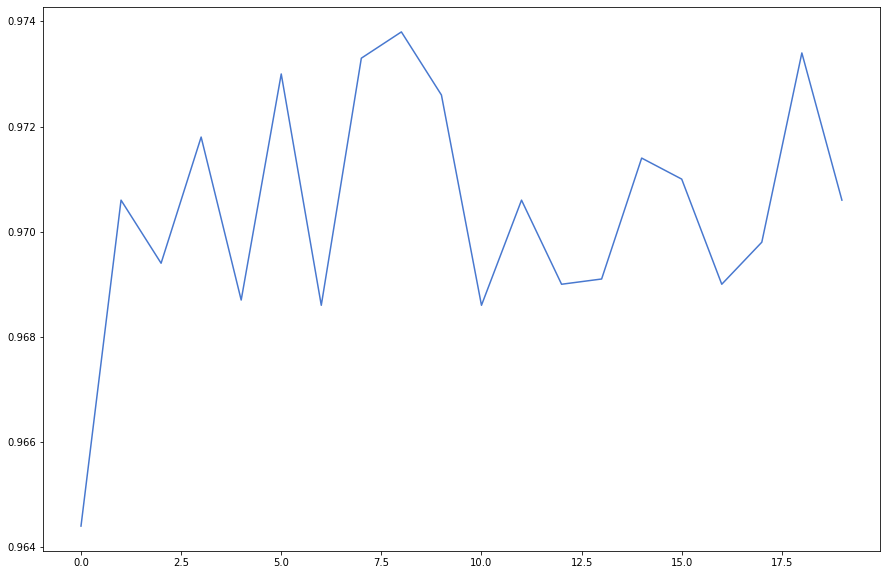

In [93]:
plt.figure(figsize=(15,10))
plt.plot([0.9644, 0.9706 ,0.9694 ,0.9718 , 0.9687 ,0.9730 ,0.9686, 0.9733 ,0.9738 ,0.9726,0.9686  ,0.9706 ,0.9690,0.9691 ,0.9714 ,0.9710,0.9690 ,0.9698,0.9734 ,0.9706    ])

In [92]:
torch.save(sum_model.state_dict(), "result.model")

In [81]:
import json
with open("reverse_dict.json", "w") as fp:
    json.dump(dataset.y_dict_reverse , fp) 